In [5]:
# use the scipy to read the .mat files
import numpy as np
import scipy.io
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

np.random.seed(42)

In [6]:
# preallocate the subject classifier results 
sub_accuracy_total_all = np.zeros((21, 776))
sub_accuracy_total_ss1 = np.zeros((21, 776))
sub_accuracy_total_ss2 = np.zeros((21, 776))

sub_accuracy_total_all_perm = np.zeros((21, 776))
sub_accuracy_total_ss1_perm = np.zeros((21, 776))
sub_accuracy_total_ss2_perm = np.zeros((21, 776))

channels: 
'Fz'
'F3'
'F7'
'FC5'
'C3'
'P7'
'P3'
'Pz'
'POz'
'PO3'
'PO7'
'O1'
'Oz'
'O2'
'PO8'
'PO4'
'P4'
'P8'
'C4'
'Cz'
'FC6'
'F8'
'F4'

In [7]:
# take all eeg files in .mat (preprocessed)
import glob

filename = []
for idx, file in enumerate(glob.glob('*.mat')):
    #filename = np.append(filename, file)
    mat = scipy.io.loadmat(file)
    print(f"the subject is {file}")
    start_time = time.time()
    
    nBlocks = mat['class']['nBlocks'][0,0][0,0]
    nBins = mat['class']['nBins'][0,0][0,0]
    nIter= mat['class']['nIter'][0,0][0,0]
    nTime = mat['class']['time'][0,0][0]
    nSamps = len(mat['class']['time'][0,0][0])
    labels = mat['labels']
    blockNum = mat['blockNum']
    nIter = 50
    
    blockDat_total = mat['data']['blockDat_total'][0][0]
    blockDat_total_SS1 = mat['data']['blockDat_total_SS1'][0][0]
    blockDat_total_SS2 = mat['data']['blockDat_total_SS2'][0][0]
    
    # get the posterior channels data
    blockDat_total = blockDat_total[:,8:16,:,:]
    blockDat_total_SS1 = blockDat_total_SS1[:,8:16,:,:]
    blockDat_total_SS2 = blockDat_total_SS2[:,8:16,:,:]
    
    # Initialize empty arrays for storing accuracy
    accuracy_total_all = np.zeros((nBlocks, nSamps, nIter))
    accuracy_total_ss1 = np.zeros((nBlocks, nSamps, nIter))
    accuracy_total_ss2 = np.zeros((nBlocks, nSamps, nIter))
    
    # Create an instance of Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', store_covariance=True, tol=0.0001)

    # training the LDA model
    for ite in range(nIter):
        for t in range(nSamps):
            de_All = blockDat_total[:,:,t,ite]
            de_SS1 = blockDat_total_SS1[:,:,t,ite]
            de_SS2 = blockDat_total_SS2[:,:,t,ite]
            # dt_All = blockDat_total[:,:,t,ite]
            for i in range(nBlocks):
                y_train = labels[blockNum[:,1]!=i+1,ite]
                y_test = labels[blockNum[:,1]==i+1,ite]

                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_All[blockNum[:,1]==i+1,:]

                # Fit the model on the training data
                lda.fit(X_train, y_train)
                # Make predictions on the testing data
                y_pred = lda.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_all[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS1
            for i in range(nBlocks):
                y_train = labels[blockNum[:,1]!=i+1,ite]
                y_test = labels[blockNum[:,1]==i+1,ite]

                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS1[blockNum[:,1]==i+1,:]

                # Fit the model on the training data
                lda.fit(X_train, y_train)
                # Make predictions on the testing data
                y_pred = lda.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss1[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS2
            for i in range(nBlocks):
                y_train = labels[blockNum[:,1]!=i+1,ite]
                y_test = labels[blockNum[:,1]==i+1,ite]

                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS2[blockNum[:,1]==i+1,:]

                # Fit the model on the training data
                lda.fit(X_train, y_train)
                # Make predictions on the testing data
                y_pred = lda.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss2[i, t, ite] = accuracy_score(y_test, y_pred)

    # take the subject's classification response to the group array
    sub_accuracy_total_all[idx, :] = np.mean(np.mean(accuracy_total_all,2),0)
    sub_accuracy_total_ss1[idx, :] = np.mean(np.mean(accuracy_total_ss1,2),0)
    sub_accuracy_total_ss2[idx, :] = np.mean(np.mean(accuracy_total_ss2,2),0)
                
                
    # have the permutation
    # Initialize empty arrays for storing accuracy
    accuracy_total_all_perm = np.zeros((nBlocks, nSamps, nIter))
    accuracy_total_ss1_perm = np.zeros((nBlocks, nSamps, nIter))
    accuracy_total_ss2_perm = np.zeros((nBlocks, nSamps, nIter))
    
    # Create an instance of Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', store_covariance=True, tol=0.0001)
    
    # training the LDA model
    for ite in range(nIter):
        for t in range(nSamps):
            de_All = blockDat_total[:,:,t,ite]
            de_SS1 = blockDat_total_SS1[:,:,t,ite]
            de_SS2 = blockDat_total_SS2[:,:,t,ite]
            # dt_All = blockDat_total[:,:,t,ite]
            for i in range(nBlocks):
                y_train = np.random.permutation(labels[blockNum[:,1]!=i+1,ite])
                y_test = np.random.permutation(labels[blockNum[:,1]==i+1,ite])

                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_All[blockNum[:,1]==i+1,:]

                # Fit the model on the training data
                lda.fit(X_train, y_train)
                # Make predictions on the testing data
                y_pred = lda.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_all_perm[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS1
            for i in range(nBlocks):
                y_train = np.random.permutation(labels[blockNum[:,1]!=i+1,ite])
                y_test = np.random.permutation(labels[blockNum[:,1]==i+1,ite])

                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS1[blockNum[:,1]==i+1,:]

                # Fit the model on the training data
                lda.fit(X_train, y_train)
                # Make predictions on the testing data
                y_pred = lda.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss1_perm[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS2
            for i in range(nBlocks):
                y_train = np.random.permutation(labels[blockNum[:,1]!=i+1,ite])
                y_test = np.random.permutation(labels[blockNum[:,1]==i+1,ite])

                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS2[blockNum[:,1]==i+1,:]

                # Fit the model on the training data
                lda.fit(X_train, y_train)
                # Make predictions on the testing data
                y_pred = lda.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss2_perm[i, t, ite] = accuracy_score(y_test, y_pred)
    
    # take the subject's classification response to the group array
    sub_accuracy_total_all_perm[idx, :] = np.mean(np.mean(accuracy_total_all_perm,2),0)
    sub_accuracy_total_ss1_perm[idx, :] = np.mean(np.mean(accuracy_total_ss1_perm,2),0)
    sub_accuracy_total_ss2_perm[idx, :] = np.mean(np.mean(accuracy_total_ss2_perm,2),0)
    
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"The subject {idx+1} took {elapsed_time:.2f} seconds to execute.")

the subject is 12.mat
The subject 1 took 3390.10 seconds to execute.
the subject is 13.mat
The subject 2 took 3366.27 seconds to execute.
the subject is 11.mat
The subject 3 took 3180.28 seconds to execute.
the subject is 10.mat
The subject 4 took 3121.88 seconds to execute.
the subject is 28.mat
The subject 5 took 2957.46 seconds to execute.
the subject is 14.mat
The subject 6 took 2973.14 seconds to execute.
the subject is 15.mat
The subject 7 took 2964.04 seconds to execute.
the subject is 16.mat
The subject 8 took 2966.73 seconds to execute.
the subject is 8.mat
The subject 9 took 2965.67 seconds to execute.
the subject is 9.mat
The subject 10 took 3044.80 seconds to execute.
the subject is 2.mat
The subject 11 took 3060.10 seconds to execute.
the subject is 3.mat
The subject 12 took 3047.36 seconds to execute.
the subject is 7.mat
The subject 13 took 3056.60 seconds to execute.
the subject is 27.mat
The subject 14 took 3050.77 seconds to execute.
the subject is 26.mat
The subject 

In [12]:
# save out the results
np.savez('lda_results', lda_total_all= accuracy_total_all,
                        lda_total_ss1= accuracy_total_ss1,
                        lda_total_ss2= accuracy_total_ss2,
                        lda_total_all_perm= accuracy_total_all_perm,
                        lda_total_ss1_perm= accuracy_total_ss1_perm,
                        lda_total_ss2_perm= accuracy_total_ss2_perm)

new_data = np.load('lda_results.npz')
print(f'{new_data.files}')

['lda_total_all', 'lda_total_ss1', 'lda_total_ss2', 'lda_total_all_perm', 'lda_total_ss1_perm', 'lda_total_ss2_perm']


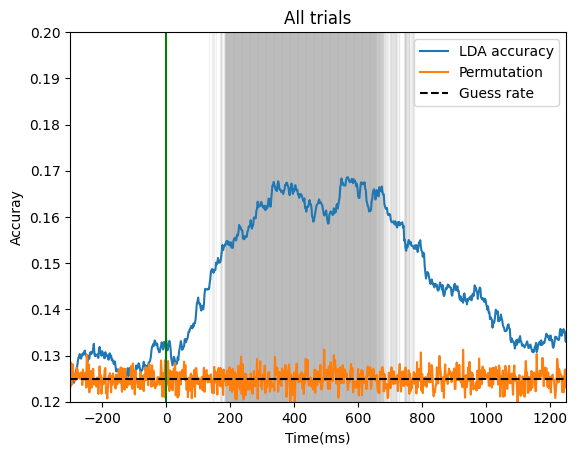

In [15]:
# do student two-sample t-test with fdr correction on ALL Trials
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

p1 = np.mean(sub_accuracy_total_all,0)
p2 = np.mean(sub_accuracy_total_all_perm,0)

# Run a t-test to compare the means of the two datasets
t_statistic, p_value = stats.ttest_ind(sub_accuracy_total_all, sub_accuracy_total_all_perm)

# Apply FDR correction to the p-values
rejected, p_values_corrected = fdrcorrection(p_value)

# Plot the classification accuracy and permutation with significant differences highlighted
fig, ax = plt.subplots()
ax.plot(nTime, p1, label='LDA accuracy')
ax.plot(nTime, p2, label='Permutation')
ax.plot(nTime, [1/nBins]*len(nTime), linestyle='--', color='black',label='Guess rate')
ax.axvline(x=0, color='green')
ax.set_title('All trials')
ax.set_ylabel('Accuray')
ax.set_ylim([0.12, 0.20])
ax.set_xlabel('Time(ms)')
ax.set_xlim([nTime[0], nTime[-1]])
for i, p in enumerate(p_values_corrected):
    if p < 0.05:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='grey')
ax.legend()
plt.savefig('lda_all_result.png')
plt.show()

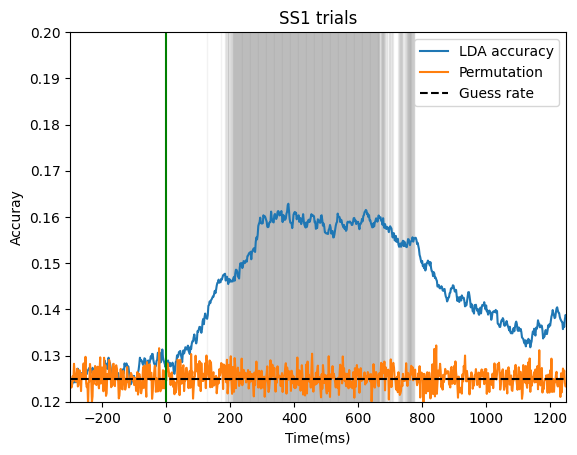

In [16]:
# do student two-sample t-test with fdr correction on SS1 Trials
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

p1 = np.mean(sub_accuracy_total_ss1,0)
p2 = np.mean(sub_accuracy_total_ss1_perm,0)

# Run a t-test to compare the means of the two datasets
t_statistic, p_value = stats.ttest_ind(sub_accuracy_total_ss1, sub_accuracy_total_ss1_perm)

# Apply FDR correction to the p-values
rejected, p_values_corrected = fdrcorrection(p_value)

# Plot the classification accuracy and permutation with significant differences highlighted
fig, ax = plt.subplots()
ax.plot(nTime, p1, label='LDA accuracy')
ax.plot(nTime, p2, label='Permutation')
ax.plot(nTime, [1/nBins]*len(nTime), linestyle='--', color='black',label='Guess rate')
ax.axvline(x=0, color='green')
ax.set_title('SS1 trials')
ax.set_ylabel('Accuray')
ax.set_ylim([0.12, 0.20])
ax.set_xlabel('Time(ms)')
ax.set_xlim([nTime[0], nTime[-1]])
for i, p in enumerate(p_values_corrected):
    if p < 0.05:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='grey')
ax.legend()
plt.savefig('lda_ss1_result.png')
plt.show()

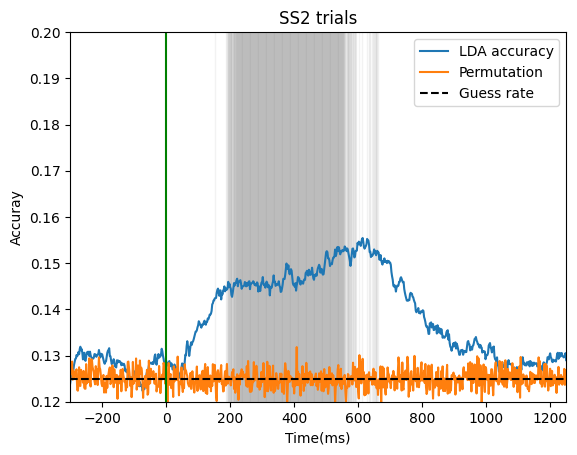

In [17]:
# do student two-sample t-test with fdr correction on SS1 Trials
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

p1 = np.mean(sub_accuracy_total_ss2,0)
p2 = np.mean(sub_accuracy_total_ss2_perm,0)

# Run a t-test to compare the means of the two datasets
t_statistic, p_value = stats.ttest_ind(sub_accuracy_total_ss2, sub_accuracy_total_ss2_perm)

# Apply FDR correction to the p-values
rejected, p_values_corrected = fdrcorrection(p_value)

# Plot the classification accuracy and permutation with significant differences highlighted
fig, ax = plt.subplots()
ax.plot(nTime, p1, label='LDA accuracy')
ax.plot(nTime, p2, label='Permutation')
ax.plot(nTime, [1/nBins]*len(nTime), linestyle='--', color='black',label='Guess rate')
ax.axvline(x=0, color='green')
ax.set_title('SS2 trials')
ax.set_ylabel('Accuray')
ax.set_ylim([0.12, 0.20])
ax.set_xlabel('Time(ms)')
ax.set_xlim([nTime[0], nTime[-1]])
for i, p in enumerate(p_values_corrected):
    if p < 0.05:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='grey')
ax.legend()
plt.savefig('lda_ss2_result.png')
plt.show()